## 1. Loading data

### 1.1. Loading libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import time
import torch
import torch.nn as nn
import seaborn as sns
import math
import calendar
from sklearn.metrics import mean_squared_error
import pytorch_lightning as pl
import warnings
warnings.filterwarnings("ignore")

C:\Users\Przem\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Przem\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Przem\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Przem\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.

## 2. Preparing data for analysis

### 2.1. Data preprocessing

In [2]:
df = pd.read_excel('2019-2020.xlsx', skiprows=2)

In [3]:
df

,data obrotu,data dostawy,godzina dostawy,kurs fixingu I (PLN/MWh),wolumen fixingu I (MWh),kurs fixingu II (PLN/MWh),wolumen fixingu II (MWh),kurs notowan ciaglych (PLN/MWh),wolumen notowan ciaglych (MWh)
0,2019-01-01,2019-01-02,1,40.00,4021.5,19.85,1372.6,20.00,34.50
1,2019-01-01,2019-01-02,2,31.00,3950.2,2023-09-01 00:00:00,1389.6,10.00,2020-10-29 00:00:00
2,2019-01-01,2019-01-02,3,31.00,3951.8,2020-01-05 00:00:00,1345.9,1959-09-01 00:00:00,39.40
3,2019-01-01,2019-01-02,4,31.00,3991.2,1988-09-01 00:00:00,1434.5,1959-09-01 00:00:00,39.40
4,2019-01-01,2019-01-02,5,31.00,4035.3,1993-09-01 00:00:00,1451.8,10.00,19.30
...,...,...,...,...,...,...,...,...,...
17418,2020-12-25,2020-12-26,19,198.81,3385.1,NaN,NaN,NaN,NaN
17419,2020-12-25,2020-12-26,20,195.00,3208.2,NaN,NaN,NaN,NaN
17420,2020-12-25,2020-12-26,21,186.03,2951.0,NaN,NaN,NaN,NaN
17421,2020-12-25,2020-12-26,22,174.75,2774.2,NaN,NaN,NaN,NaN


In [4]:
df.head(10).style.set_table_styles(
[{'selector': 'th',
  'props': [('background', '#008080'), 
            ('color', 'white'),
            ('font-family', 'verdana')]},
 {'selector': 'td',
  'props': [('font-family', 'verdana'),
            ('color', 'black')]},

 {'selector': 'tr:nth-of-type(odd)',
  'props': [('background', '#DCDCDC')]}, 
 
  {'selector': 'tr:nth-of-type(even)',
  'props': [('background', 'white')]},
 
  {'selector': 'tr:hover',
  'props': [('background', 'yellow')]},
]).hide_index()

data obrotu,data dostawy,godzina dostawy,kurs fixingu I (PLN/MWh),wolumen fixingu I (MWh),kurs fixingu II (PLN/MWh),wolumen fixingu II (MWh),kurs notowan ciaglych (PLN/MWh),wolumen notowan ciaglych (MWh)
2019-01-01 00:00:00,2019-01-02 00:00:00,1,40.000000,4021.500000,19.85,1372.600000,20.00,34.50
2019-01-01 00:00:00,2019-01-02 00:00:00,2,31.000000,3950.200000,2023-09-01 00:00:00,1389.600000,10.00,2020-10-29 00:00:00
2019-01-01 00:00:00,2019-01-02 00:00:00,3,31.000000,3951.800000,2020-01-05 00:00:00,1345.900000,1959-09-01 00:00:00,39.40
2019-01-01 00:00:00,2019-01-02 00:00:00,4,31.000000,3991.200000,1988-09-01 00:00:00,1434.500000,1959-09-01 00:00:00,39.40
2019-01-01 00:00:00,2019-01-02 00:00:00,5,31.000000,4035.300000,1993-09-01 00:00:00,1451.800000,10.00,19.30
2019-01-01 00:00:00,2019-01-02 00:00:00,6,45.000000,4210.700000,26.41,1478.400000,20.00,1970-07-01 00:00:00
2019-01-01 00:00:00,2019-01-02 00:00:00,7,108.500000,3822.300000,189.24,1017.200000,-,-
2019-01-01 00:00:00,2019-01-02 00:00:00,8,175.070000,5218.100000,213.27,1041.300000,-,-
2019-01-01 00:00:00,2019-01-02 00:00:00,9,197.940000,4519.800000,214.63,715.000000,-,-
2019-01-01 00:00:00,2019-01-02 00:00:00,10,201.980000,3911.200000,217.98,657.400000,218.00,9.00


In [5]:
df.shape

(17423, 9)

In [6]:
df['godzina dostawy'].isnull().sum()

0

In [7]:
df['godzina dostawy'] = pd.to_numeric(df['godzina dostawy'], errors='coerce')
df['date'] = pd.to_datetime(df['data dostawy']) + pd.to_timedelta(df['godzina dostawy'], unit='h')

df = pd.DataFrame(data={'date': df['date'], 'fixing I course (PLN/MWh)':df['kurs fixingu I (PLN/MWh)']})
df['month'] = pd.DatetimeIndex(df['date']).month
df['month_name'] = pd.to_datetime(df['month'], format='%m').dt.month_name()
df['hour'] = df.date.dt.hour
df['week'] = pd.to_datetime(df['date']).dt.week
df['date_normalize'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d') 
df['day_of_week'] = pd.to_datetime(df['date']).dt.dayofweek
df['day_of_month'] = pd.to_datetime(df['date_normalize']).dt.day
df['md'] = pd.to_datetime(df['date']).dt.strftime('%m-%d') 

In [8]:
type(df['day_of_week'])

pandas.core.series.Series

In [9]:
def season_of_date(date):
    
    seasons = {'spring': pd.date_range(start='2019-03-21', end='2019-06-20').strftime('%m-%d'),
               'summer': pd.date_range(start='2019-06-21', end='2019-09-22').strftime('%m-%d'),
               'autumn': pd.date_range(start='2019-09-23', end='2019-12-20').strftime('%m-%d')}
    if date in seasons['spring']:
        return 'Spring'
    if date in seasons['summer']:
        return 'Summer'
    if date in seasons['autumn']:
        return 'Autumn'
    else:
        return 'Winter'
    

In [10]:
def polish_label_weekday(row):
    
    if row['day_of_week'] == 0:
        return 'Poniedziałek'
    if row['day_of_week'] == 1:
        return 'Wtorek'
    if row['day_of_week'] == 2:
        return 'Środa'
    if row['day_of_week'] == 3:
        return 'Czwartek'
    if row['day_of_week'] == 4:
        return 'Piątek'
    if row['day_of_week'] == 5:
        return 'Sobota'
    if row['day_of_week'] == 6:
        return 'Niedziela'
    
    
# names of months in Polish 
def polish_label_month(row):
    if row['month_name'] == 'January':
        return 'Styczeń'
    if row['month_name'] == 'February':
        return 'Luty'
    if row['month_name'] == 'March':
        return 'Marzec'
    if row['month_name'] == 'April':
        return 'Kwiecień'
    if row['month_name'] == 'May':
        return 'Maj'
    if row['month_name'] == 'June':
        return 'Czerwiec'
    if row['month_name'] == 'July':
        return 'Lipiec'
    if row['month_name'] == 'August':
        return 'Sierpień'
    if row['month_name'] == 'September':
        return 'Wrzesień'
    if row['month_name'] == 'October':
        return 'Październik'
    if row['month_name'] == 'November':
        return 'Listopad'
    if row['month_name'] == 'December':
        return 'Grudzień'
    
    
# names of seasons in Polish 
def polish_label_season(row):
    if row['season'] == 'Winter':
        return 'Zima'
    if row['season'] == 'Spring':
        return 'Wiosna'
    if row['season'] == 'Summer':
        return 'Lato'
    if row['season'] == 'Autumn':
        return 'Jesien'

# names of months in Polish 
def polish_label_quarter(row):
    if row['month_name'] == 'January' or row['month_name'] == 'February' or row['month_name'] == 'March':
        return '1'
    if row['month_name'] == 'April' or row['month_name'] == 'May' or row['month_name'] == 'June' :
        return '2'
    if row['month_name'] == 'July' or row['month_name'] == 'August' or row['month_name'] == 'September':
        return '3'
    if row['month_name'] == 'October' or row['month_name'] == 'November' or row['month_name'] == 'December':
        return '4'


In [11]:
df['season'] = df.md.map(season_of_date)

In [12]:
df['pl_weekday'] = df.apply(lambda row: polish_label_weekday(row), axis=1)
df['pl_month_name'] = df.apply(lambda row: polish_label_month(row), axis=1)
df['pl_season_name'] = df.apply(lambda row: polish_label_season(row), axis=1)
df['quarter'] = df.apply(lambda row: polish_label_quarter(row), axis=1)

In [13]:
df2019 = df[df['date']<'2020-01-01 00:00:00'].reset_index(drop=True)
df2020 = df[df['date']>='2020-01-01 00:00:00'].reset_index(drop=True)


In [14]:
df2019

,date,fixing I course (PLN/MWh),month,month_name,hour,week,date_normalize,day_of_week,day_of_month,md,season,pl_weekday,pl_month_name,pl_season_name,quarter
0,2019-01-02 01:00:00,40.00,1.0,January,1.0,1.0,2019-01-02,2.0,2.0,01-02,Winter,Środa,Styczeń,Zima,1
1,2019-01-02 02:00:00,31.00,1.0,January,2.0,1.0,2019-01-02,2.0,2.0,01-02,Winter,Środa,Styczeń,Zima,1
2,2019-01-02 03:00:00,31.00,1.0,January,3.0,1.0,2019-01-02,2.0,2.0,01-02,Winter,Środa,Styczeń,Zima,1
3,2019-01-02 04:00:00,31.00,1.0,January,4.0,1.0,2019-01-02,2.0,2.0,01-02,Winter,Środa,Styczeń,Zima,1
4,2019-01-02 05:00:00,31.00,1.0,January,5.0,1.0,2019-01-02,2.0,2.0,01-02,Winter,Środa,Styczeń,Zima,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8729,2019-12-31 19:00:00,185.00,12.0,December,19.0,1.0,2019-12-31,1.0,31.0,12-31,Winter,Wtorek,Grudzień,Zima,4
8730,2019-12-31 20:00:00,172.28,12.0,December,20.0,1.0,2019-12-31,1.0,31.0,12-31,Winter,Wtorek,Grudzień,Zima,4
8731,2019-12-31 21:00:00,157.63,12.0,December,21.0,1.0,2019-12-31,1.0,31.0,12-31,Winter,Wtorek,Grudzień,Zima,4
8732,2019-12-31 22:00:00,149.99,12.0,December,22.0,1.0,2019-12-31,1.0,31.0,12-31,Winter,Wtorek,Grudzień,Zima,4


In [15]:
df2019_monthly = df2019.groupby(['month_name']).agg({'fixing I course (PLN/MWh)':['mean', 'std']}).reset_index()
df2020_monthly = df2020.groupby(['month_name']).agg({'fixing I course (PLN/MWh)':['mean', 'std']}).reset_index()

df2019_monthly = df2019_monthly.rename(columns={"fixing I course (PLN/MWh)": "fixing I course 2019"}) 
df2020_monthly = df2020_monthly.rename(columns={"fixing I course (PLN/MWh)": "fixing I course 2020"}) 

df_fx_monthly = pd.merge(df2019_monthly, df2020_monthly, how='inner', on=['month_name']) 

In [16]:
cats = ["January", "February", "March", "April", "May", 
        "June", "July", "August", "September", "October", "November", "December"]
df_fx_monthly['month_name'] = pd.Categorical(df_fx_monthly['month_name'], categories=cats, ordered=True)
df_fx_monthly = df_fx_monthly.sort_values('month_name').reset_index(drop=True)

In [17]:
df_fx_monthly

month_name fixing I course 2019            fixing I course 2020           
                              mean        std                 mean        std
0     January           246.159666  61.076298           191.011062  43.146024
1    February           214.887188  41.679537           176.725517  52.982464
2       March           199.216326  39.305834           165.831844  46.175310
3       April           227.157708  41.537521           151.707708  29.625892
4         May           240.303602  41.354861           172.192137  31.405487
5        June           250.604653  54.178740           217.278208  33.618817
6        July           239.451022  43.920551           222.505618  24.483365
7      August           267.395685  35.212064           231.319597  36.808373
8   September           243.292347  38.327626           242.856528  42.755387
9     October           229.913199  40.728084           240.093992  45.131155
10   November           215.854097  38.477430           243.809625  51.683986
11   December           189.271398  47.748601           262.089506  74.088921

### 2.2. Checking outliers 

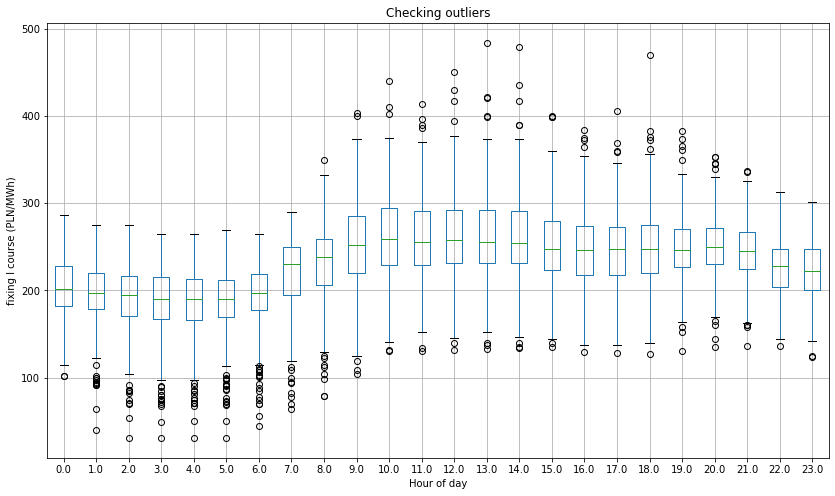

In [18]:
# box-plot to check outliers in individual hours for 2019
outpoints_hourly_2019 = df2019.pivot_table(index='date_normalize', 
                     columns=df2019['hour'], 
                     values='fixing I course (PLN/MWh)', 
                     aggfunc='mean').boxplot(figsize=(14,8)).set(title = "Checking outliers", xlabel = "Hour of day", ylabel = "fixing I course (PLN/MWh)")

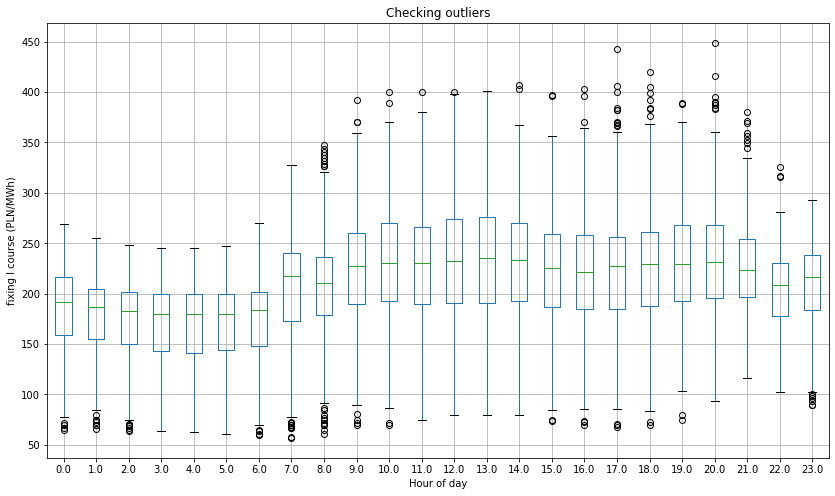

In [19]:
# box-plot to check outliers in individual hours for 2020
outpoints_hourly_2020 = df2020.pivot_table(index='date_normalize', 
                     columns=df2020['hour'], 
                     values='fixing I course (PLN/MWh)', 
                     aggfunc='mean').boxplot(figsize=(14,8)).set(title = "Checking outliers", xlabel = "Hour of day", ylabel = "fixing I course (PLN/MWh)")

In [20]:
df2019.to_excel("data_2019.xlsx")  
df2020.to_excel("data_2020.xlsx")  

In [21]:
df

,date,fixing I course (PLN/MWh),month,month_name,hour,week,date_normalize,day_of_week,day_of_month,md,season,pl_weekday,pl_month_name,pl_season_name,quarter
0,2019-01-02 01:00:00,40.00,1.0,January,1.0,1.0,2019-01-02,2.0,2.0,01-02,Winter,Środa,Styczeń,Zima,1
1,2019-01-02 02:00:00,31.00,1.0,January,2.0,1.0,2019-01-02,2.0,2.0,01-02,Winter,Środa,Styczeń,Zima,1
2,2019-01-02 03:00:00,31.00,1.0,January,3.0,1.0,2019-01-02,2.0,2.0,01-02,Winter,Środa,Styczeń,Zima,1
3,2019-01-02 04:00:00,31.00,1.0,January,4.0,1.0,2019-01-02,2.0,2.0,01-02,Winter,Środa,Styczeń,Zima,1
4,2019-01-02 05:00:00,31.00,1.0,January,5.0,1.0,2019-01-02,2.0,2.0,01-02,Winter,Środa,Styczeń,Zima,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17418,2020-12-26 19:00:00,198.81,12.0,December,19.0,52.0,2020-12-26,5.0,26.0,12-26,Winter,Sobota,Grudzień,Zima,4
17419,2020-12-26 20:00:00,195.00,12.0,December,20.0,52.0,2020-12-26,5.0,26.0,12-26,Winter,Sobota,Grudzień,Zima,4
17420,2020-12-26 21:00:00,186.03,12.0,December,21.0,52.0,2020-12-26,5.0,26.0,12-26,Winter,Sobota,Grudzień,Zima,4
17421,2020-12-26 22:00:00,174.75,12.0,December,22.0,52.0,2020-12-26,5.0,26.0,12-26,Winter,Sobota,Grudzień,Zima,4


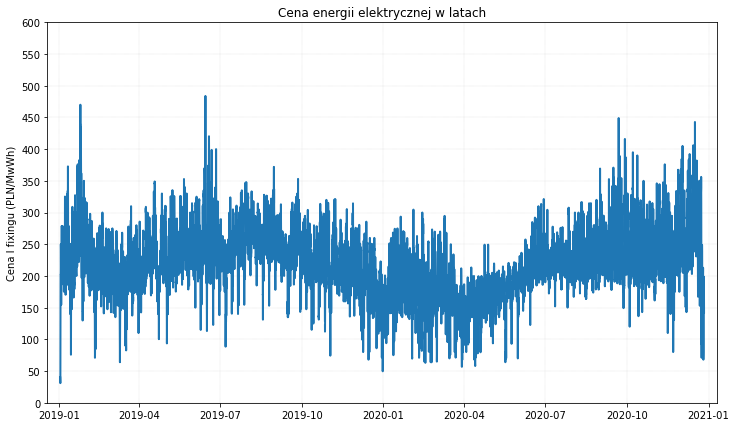

In [22]:
fig = plt.subplots(figsize=(12,7))

plt.plot(df['date'], df['fixing I course (PLN/MWh)'], label = 'line 1',
        linewidth=2.0)

# plt.fill_between(df2019_daily['date_normalize'], df2019_daily['fixing I course (PLN/MWh)'], alpha=0.2)
plt.title('Cena energii elektrycznej w latach',fontsize=12)
my_xticks = np.array(df['date_normalize'])
# frequency = 30
# plt.xticks(my_xticks[::frequency], my_xticks[::frequency], rotation=60)
plt.ylabel("Cena I fixingu (PLN/MwWh)")
plt.margins(0.02)
plt.ylim(120,270, 30)
plt.yticks(np.arange(0, 650, 50))

#plt.grid(color='gray', linestyle=':', linewidth=0.35, alpha=0.6, axis='both')
plt.grid(color='gray', linestyle=':', linewidth=0.35, alpha=0.6, axis='both')
#plt.grid()



plt.show()

In [23]:
df_daily = df.groupby(['date_normalize']).agg({'fixing I course (PLN/MWh)':np.mean}).reset_index()

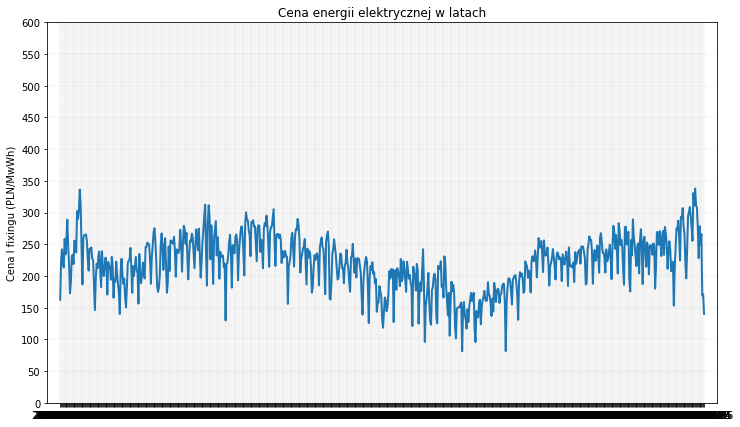

In [24]:
fig = plt.subplots(figsize=(12,7))

plt.plot(df_daily['date_normalize'], df_daily['fixing I course (PLN/MWh)'], label = 'line 1',
        linewidth=2.0)

# plt.fill_between(df2019_daily['date_normalize'], df2019_daily['fixing I course (PLN/MWh)'], alpha=0.2)
plt.title('Cena energii elektrycznej w latach',fontsize=12)
my_xticks = np.array(df_daily['date_normalize'])
# frequency = 30
# plt.xticks(my_xticks[::frequency], my_xticks[::frequency], rotation=60)
plt.ylabel("Cena I fixingu (PLN/MwWh)")
plt.margins(0.02)
plt.ylim(120,270, 30)
plt.yticks(np.arange(0, 650, 50))

plt.grid(color='gray', linestyle=':', linewidth=0.35, alpha=0.6, axis='both')
#plt.grid()



plt.show()

## 3. Exploratory data analysis

In [25]:
df2019_monthly = df2019.groupby(['month_name']).agg({'fixing I course (PLN/MWh)':['mean', 'std']}).reset_index()
df2020_monthly = df2020.groupby(['month_name']).agg({'fixing I course (PLN/MWh)':['mean', 'std']}).reset_index()

In [26]:
df2019_monthly = df2019_monthly.rename(columns={"fixing I course (PLN/MWh)": "fixing I course 2019"}) 
df2020_monthly = df2020_monthly.rename(columns={"fixing I course (PLN/MWh)": "fixing I course 2020"}) 

In [27]:
df_fx_monthly = pd.merge(df2019_monthly, df2020_monthly, how='inner', on=['month_name']) 

In [28]:
cats = ["January", "February", "March", "April", "May", "June", 
        "July", "August", "September", "October", "November", "December"]
df_fx_monthly['month_name'] = pd.Categorical(df_fx_monthly['month_name'], categories=cats, ordered=True)
df_fx_monthly = df_fx_monthly.sort_values('month_name').reset_index(drop=True)

In [29]:
df_fx_monthly.columns = df_fx_monthly.columns.get_level_values(0)

In [30]:
df_fx_monthly.columns.values[1] = "fixing I course 2019_mean"
df_fx_monthly.columns.values[2] = "fixing I course 2019_std"
df_fx_monthly.columns.values[3] = "fixing I course 2020_mean"
df_fx_monthly.columns.values[4] = "fixing I course 2020_std"

In [31]:
df_fx_monthly['pl_month_name'] = df_fx_monthly.apply(lambda row: polish_label_month(row), axis=1)

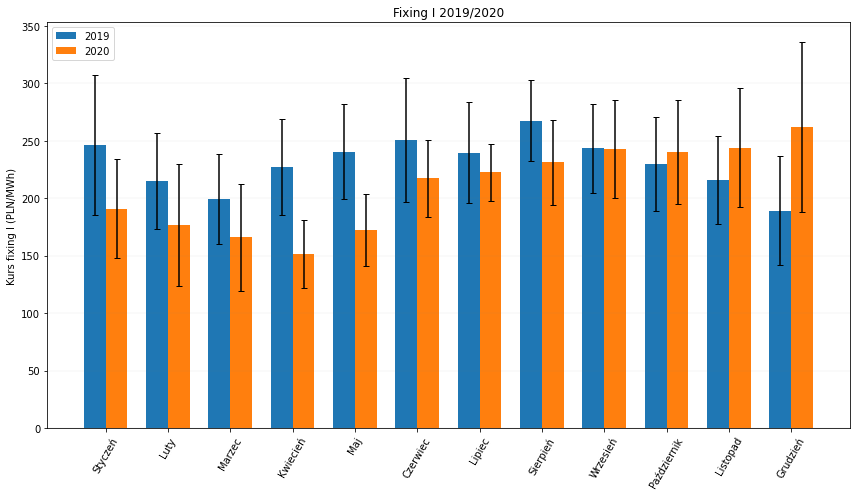

In [32]:
ind = np.arange(len(df_fx_monthly['fixing I course 2019_mean']))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots(
figsize=(12,7))
rects1 = ax.bar(ind - width/2, df_fx_monthly['fixing I course 2019_mean'] , width, yerr=df_fx_monthly['fixing I course 2019_std'],
                label='2019', capsize=3)
rects2 = ax.bar(ind + width/2, df_fx_monthly['fixing I course 2020_mean'], width, yerr=df_fx_monthly['fixing I course 2020_std'],
                label='2020', capsize=3)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Kurs fixing I (PLN/MWh)')
ax.set_title('Fixing I 2019/2020')
ax.set_xticks(ind)
ax.set_xticklabels(df_fx_monthly['pl_month_name'], rotation=60)
ax.grid(color='grey', linestyle='-', linewidth=0.15, alpha=0.5, axis = 'y')
ax.legend()


fig.tight_layout()

plt.show()

In [33]:
cats = ["Poniedziałek", "Wtorek", "Środa", "Czwartek", "Piątek", "Sobota", "Niedziela"]
df2020['pl_weekday'] = pd.Categorical(df2020['pl_weekday'], categories=cats, ordered=True)

In [34]:
#new_df = df2020.copy()

In [35]:
#new_df.rename(columns={"pl_weekday": "Dzień tygodnia"})

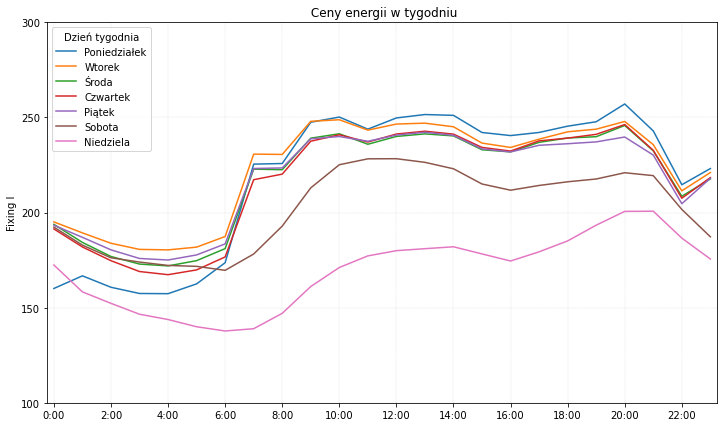

In [36]:
hourly_weekday_rent = df2020.pivot_table(index=df2020['date'].dt.hour, 
                     columns='pl_weekday', 
                     values='fixing I course (PLN/MWh)', 
                     aggfunc='mean')


hourly_weekday_rent.plot(figsize=(12,7)).set(title = " Ceny energii w tygodniu", ylabel = 'Fixing I', xlabel=None)
plt.grid(color='gray', linestyle=':', linewidth=0.35, alpha=0.6, axis='both')
plt.legend(title="Dzień tygodnia")
plt.margins(0.01)
#plt.ylim(np.arange(0, 23, 2))
plt.yticks(np.arange(100, 350, 50))
x = np.arange(0, 23, 2)
labels = ['0:00', '2:00', '4:00', '6:00', '8:00', '10:00', '12:00', '14:00', '16:00', '18:00', '20:00', '22:00']
plt.xticks(x, labels)
#plt.savefig('wykres.eps', format='eps')
plt.show()

### 3.1. Energy market analysis

In [37]:
#df2019

In [38]:
import statistics

In [39]:
smallest_hourly_fixing_price_2019 = min(df2019['fixing I course (PLN/MWh)'])
print('The lowest hourly electricity price in 2019 is: ', smallest_hourly_fixing_price_2019, "PLN/MWh")
biggest_hourly_fixing_price_2019 = max(df2019['fixing I course (PLN/MWh)'])
print('The largest hourly electricity price in 2019 is: ', biggest_hourly_fixing_price_2019, "PLN/MWh")
average_hourly_fixing_price_2019 = statistics.mean(df2019['fixing I course (PLN/MWh)'])
print('Average hourly electricity price in 2019 is: ', average_hourly_fixing_price_2019, "PLN/MWh")

The lowest hourly electricity price in 2019 is:  31.0 PLN/MWh
The largest hourly electricity price in 2019 is:  483.82 PLN/MWh
Average hourly electricity price in 2019 is:  230.33412296771237 PLN/MWh


In [40]:
smallest_hourly_fixing_price_2020 = min(df2020['fixing I course (PLN/MWh)'])
print('The lowest hourly electricity price in 2020 is: ', smallest_hourly_fixing_price_2020, "PLN/MWh")
biggest_hourly_fixing_price_2020 = max(df2020['fixing I course (PLN/MWh)'])
print('The largest hourly electricity price in 2020 is: ', biggest_hourly_fixing_price_2020, "PLN/MWh")
average_hourly_fixing_price_2020 = statistics.mean(df2020['fixing I course (PLN/MWh)'])
print('Average hourly electricity price in 2020 is: ', average_hourly_fixing_price_2020, "PLN/MWh")

The lowest hourly electricity price in 2020 is:  56.73 PLN/MWh
The largest hourly electricity price in 2020 is:  449.0 PLN/MWh
Average hourly electricity price in 2020 is:  209.3492091631173 PLN/MWh


In [41]:
df2020['date'].astype(str).str[11:16]

0       00:00
1       01:00
2       02:00
3       03:00
4       04:00
        ...  
8682    19:00
8683    20:00
8684    21:00
8685    22:00
8686    23:00
Name: date, Length: 8687, dtype: object

In [42]:
df_fx_hourly = df2020.groupby(['hour']).agg({'fixing I course (PLN/MWh)':np.mean})
df_fx_hourly = df_fx_hourly.reset_index() 

In [43]:
df_fx_hourly

,hour,fixing I course (PLN/MWh)
0,0.0,185.584834
1,1.0,178.690746
2,2.0,172.263573
3,3.0,168.109171
4,4.0,166.917597
5,5.0,168.387265
6,6.0,172.866796
7,7.0,205.305055
8,8.0,209.004365
9,9.0,226.499972


In [44]:
df2020['date'].astype(str).str[11:16]

0       00:00
1       01:00
2       02:00
3       03:00
4       04:00
        ...  
8682    19:00
8683    20:00
8684    21:00
8685    22:00
8686    23:00
Name: date, Length: 8687, dtype: object

In [45]:
df_fx_hourly['h-m']=df2020['date'].astype(str).str[11:16]

In [46]:
df_fx_hourly['fixing I course (PLN/MWh)'][0] = df_fx_hourly['fixing I course (PLN/MWh)'][1]

In [47]:
df_fx_hourly

,hour,fixing I course (PLN/MWh),h-m
0,0.0,178.690746,00:00
1,1.0,178.690746,01:00
2,2.0,172.263573,02:00
3,3.0,168.109171,03:00
4,4.0,166.917597,04:00
5,5.0,168.387265,05:00
6,6.0,172.866796,06:00
7,7.0,205.305055,07:00
8,8.0,209.004365,08:00
9,9.0,226.499972,09:00


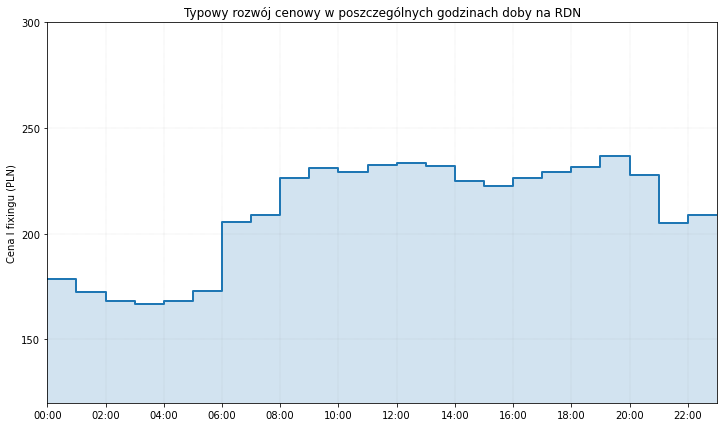

In [48]:
fig = plt.subplots(figsize=(12,7))

plt.plot(df_fx_hourly['h-m'], df_fx_hourly['fixing I course (PLN/MWh)'], ls='steps',
        linewidth=2.0)
plt.fill_between(df_fx_hourly['h-m'],df_fx_hourly['fixing I course (PLN/MWh)'], step="pre", alpha=0.2)
plt.title('Typowy rozwój cenowy w poszczególnych godzinach doby na RDN')
my_xticks = np.array(df_fx_hourly['h-m'])
frequency = 2
plt.xticks(my_xticks[::frequency], my_xticks[::frequency], rotation=0)
plt.ylabel("Cena I fixingu (PLN)")
plt.margins(0.)
plt.ylim(120,270, 30)
plt.yticks(np.arange(150, 350, 50))

plt.grid(color='gray', linestyle=':', linewidth=0.35, alpha=0.6, axis='both')
#plt.grid()



plt.show()


### Typical price development of electricity on the Day-Ahead Market in 2019-2020

In [49]:
df_fx_hourly = df.groupby(['hour']).agg({'fixing I course (PLN/MWh)':np.mean})
df_fx_hourly = df_fx_hourly.reset_index() 

In [50]:
df_fx_hourly

,hour,fixing I course (PLN/MWh)
0,0.0,195.124248
1,1.0,187.531157
2,2.0,181.237914
3,3.0,177.387534
4,4.0,176.334160
5,5.0,177.527961
6,6.0,182.639876
7,7.0,212.128953
8,8.0,219.614421
9,9.0,238.561074


In [51]:
df['date'].astype(str).str[11:16]

0        01:00
1        02:00
2        03:00
3        04:00
4        05:00
         ...  
17418    19:00
17419    20:00
17420    21:00
17421    22:00
17422    23:00
Name: date, Length: 17423, dtype: object

In [52]:
df_fx_hourly['h-m']=df2020['date'].astype(str).str[11:16]

In [53]:
df_fx_hourly['fixing I course (PLN/MWh)'][0] = df_fx_hourly['fixing I course (PLN/MWh)'][1]

In [54]:
df_fx_hourly

,hour,fixing I course (PLN/MWh),h-m
0,0.0,187.531157,00:00
1,1.0,187.531157,01:00
2,2.0,181.237914,02:00
3,3.0,177.387534,03:00
4,4.0,176.334160,04:00
5,5.0,177.527961,05:00
6,6.0,182.639876,06:00
7,7.0,212.128953,07:00
8,8.0,219.614421,08:00
9,9.0,238.561074,09:00


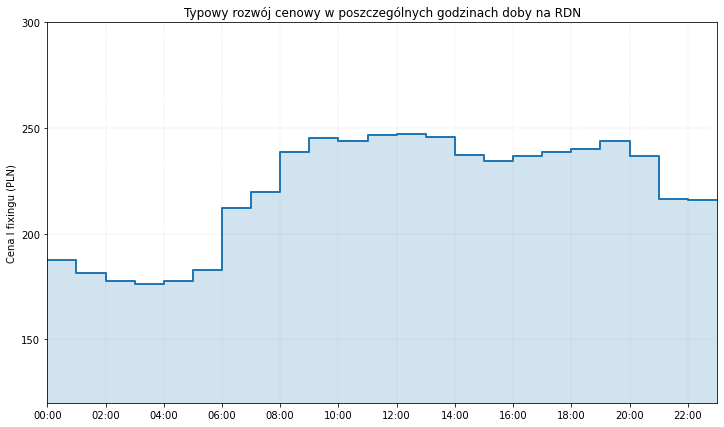

In [55]:
fig = plt.subplots(figsize=(12,7))

plt.plot(df_fx_hourly['h-m'], df_fx_hourly['fixing I course (PLN/MWh)'], ls='steps',
        linewidth=2.0)
plt.fill_between(df_fx_hourly['h-m'],df_fx_hourly['fixing I course (PLN/MWh)'], step="pre", alpha=0.2)
plt.title('Typowy rozwój cenowy w poszczególnych godzinach doby na RDN')
my_xticks = np.array(df_fx_hourly['h-m'])
frequency = 2
plt.xticks(my_xticks[::frequency], my_xticks[::frequency], rotation=0)
plt.ylabel("Cena I fixingu (PLN)")
plt.margins(0.)
plt.ylim(120,270, 30)
plt.yticks(np.arange(150, 350, 50))

plt.grid(color='gray', linestyle=':', linewidth=0.35, alpha=0.6, axis='both')
#plt.grid()



plt.show()


In [56]:
# df_fx_hourly.loc[df_fx_hourly['hour']==0, 'hour'] = 24
#df_fx_hourly = df_fx_hourly.sort_values(by=['hour'], na_position = 'first', ascending=True).reset_index(drop = True)

In [57]:
df2019_daily = df2019.groupby(['date_normalize']).agg({'fixing I course (PLN/MWh)':np.mean}).reset_index() 
df2019_daily['day_of_year'] = pd.to_datetime(df2019_daily['date_normalize']).dt.dayofyear

df2020_daily = df2020.groupby(['date_normalize']).agg({'fixing I course (PLN/MWh)':np.mean}).reset_index() 
df2020_daily['day_of_year'] = pd.to_datetime(df2020_daily['date_normalize']).dt.dayofyear

In [58]:
df2019_daily

,date_normalize,fixing I course (PLN/MWh),day_of_year
0,2019-01-02,162.571304,2
1,2019-01-03,223.377083,3
2,2019-01-04,242.027083,4
3,2019-01-05,219.932917,5
4,2019-01-06,213.270833,6
...,...,...,...
359,2019-12-27,183.994583,361
360,2019-12-28,175.540417,362
361,2019-12-29,168.481667,363
362,2019-12-30,132.883333,364


In [59]:
minmax_2019 = df2019.groupby(['date_normalize']).agg({'fixing I course (PLN/MWh)': ['min', 'max']}).reset_index()
minmax_2019['diff'] = minmax_2019['fixing I course (PLN/MWh)']['max'] - minmax_2019['fixing I course (PLN/MWh)']['min']

minmax_2020 = df2020.groupby(['date_normalize']).agg({'fixing I course (PLN/MWh)': ['min', 'max']}).reset_index()
minmax_2020['diff'] = minmax_2020['fixing I course (PLN/MWh)']['max'] - minmax_2020['fixing I course (PLN/MWh)']['min']

In [60]:
minmax_2019['diff'].describe()

count    364.000000
mean      93.608049
std       33.697546
min       31.580000
25%       71.065000
50%       89.770000
75%      110.250000
max      248.720000
Name: diff, dtype: float64

In [61]:
smallest_daily_spread_fixing_prices_2019 = min(minmax_2019['diff'])
print('The lowest daily spread of electricity prices in 2019 is: ', smallest_daily_spread_fixing_prices_2019, "PLN/MWh")

largest_daily_spread_fixing_prices_2019 = max(minmax_2019['diff'])
print('The largest daily spread of electricity prices in 2020 is: ', largest_daily_spread_fixing_prices_2019, "PLN/MWh")

average_daily_spread_fixing_prices_2020 = statistics.mean(minmax_2019['diff'])
print('Average hourly electricity price in 2020 is: ', average_daily_spread_fixing_prices_2020, "PLN/MWh")

The lowest daily spread of electricity prices in 2019 is:  31.580000000000013 PLN/MWh
The largest daily spread of electricity prices in 2020 is:  248.72 PLN/MWh
Average hourly electricity price in 2020 is:  93.60804945054946 PLN/MWh


In [62]:
smallest_daily_spread_fixing_prices_2020 = min(minmax_2020['diff'])
print('The lowest daily spread of electricity prices in 2019 is: ', smallest_daily_spread_fixing_prices_2020, "PLN/MWh")

largest_daily_spread_fixing_prices_2020 = max(minmax_2020['diff'])
print('The largest daily spread of electricity prices in 2020 is: ', largest_daily_spread_fixing_prices_2020, "PLN/MWh")

average_daily_spread_fixing_prices_2020 = statistics.mean(minmax_2020['diff'])
print('Average hourly electricity price in 2020 is: ', average_daily_spread_fixing_prices_2020, "PLN/MWh")

The lowest daily spread of electricity prices in 2019 is:  22.689999999999998 PLN/MWh
The largest daily spread of electricity prices in 2020 is:  249.27 PLN/MWh
Average hourly electricity price in 2020 is:  95.33102493074793 PLN/MWh


In [63]:
minmax_2020

date_normalize fixing I course (PLN/MWh)            diff
                                         min     max        
0       2020-01-01                    101.74  172.64   70.90
1       2020-01-02                    106.43  200.80   94.37
2       2020-01-03                    118.76  184.11   65.35
3       2020-01-04                     93.99  165.00   71.01
4       2020-01-05                    107.07  196.40   89.33
..             ...                       ...     ...     ...
356     2020-12-22                    153.11  335.41  182.30
357     2020-12-23                    153.11  356.16  203.05
358     2020-12-24                     70.95  248.70  177.75
359     2020-12-25                     96.61  212.91  116.30
360     2020-12-26                     68.00  198.81  130.81

[361 rows x 4 columns]

In [64]:
minmax_2020['diff'].describe()

count    361.000000
mean      95.331025
std       41.986721
min       22.690000
25%       60.520000
50%       89.930000
75%      118.050000
max      249.270000
Name: diff, dtype: float64

In [65]:
df2019_monthly = df2019.groupby(['month_name']).agg({'fixing I course (PLN/MWh)':np.mean}).reset_index()
df2020_monthly = df2020.groupby(['month_name']).agg({'fixing I course (PLN/MWh)':np.mean}).reset_index()

In [66]:
df2019_monthly

,month_name,fixing I course (PLN/MWh)
0,April,227.157708
1,August,267.395685
2,December,189.271398
3,February,214.887188
4,January,246.159666
5,July,239.451022
6,June,250.604653
7,March,199.216326
8,May,240.303602
9,November,215.854097


In [67]:
df2019_daily.describe()

,fixing I course (PLN/MWh),day_of_year
count,364.000000,364.000000
mean,230.317911,183.500000
std,36.339319,105.221988
min,118.285833,2.000000
25%,209.293750,92.750000
50%,232.432500,183.500000
75%,255.559687,274.250000
max,336.123333,365.000000


In [68]:
df2019_daily[0:89].describe()

,fixing I course (PLN/MWh),day_of_year
count,89.000000,89.000000
mean,219.910937,46.000000
std,36.621320,25.836021
min,140.143333,2.000000
25%,195.962917,24.000000
50%,218.675000,46.000000
75%,239.145417,68.000000
max,336.123333,90.000000


In [69]:
df2019_quarter = df2019.groupby(['quarter']).agg({'fixing I course (PLN/MWh)':np.mean}).reset_index() 
df2020_quarter = df2020.groupby(['quarter']).agg({'fixing I course (PLN/MWh)':np.mean}).reset_index() 

In [70]:
df2019[0:3100]

,date,fixing I course (PLN/MWh),month,month_name,hour,week,date_normalize,day_of_week,day_of_month,md,season,pl_weekday,pl_month_name,pl_season_name,quarter
0,2019-01-02 01:00:00,40.00,1.0,January,1.0,1.0,2019-01-02,2.0,2.0,01-02,Winter,Środa,Styczeń,Zima,1
1,2019-01-02 02:00:00,31.00,1.0,January,2.0,1.0,2019-01-02,2.0,2.0,01-02,Winter,Środa,Styczeń,Zima,1
2,2019-01-02 03:00:00,31.00,1.0,January,3.0,1.0,2019-01-02,2.0,2.0,01-02,Winter,Środa,Styczeń,Zima,1
3,2019-01-02 04:00:00,31.00,1.0,January,4.0,1.0,2019-01-02,2.0,2.0,01-02,Winter,Środa,Styczeń,Zima,1
4,2019-01-02 05:00:00,31.00,1.0,January,5.0,1.0,2019-01-02,2.0,2.0,01-02,Winter,Środa,Styczeń,Zima,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3095,2019-05-11 01:00:00,200.15,5.0,May,1.0,19.0,2019-05-11,5.0,11.0,05-11,Spring,Sobota,Maj,Wiosna,2
3096,2019-05-11 02:00:00,200.15,5.0,May,2.0,19.0,2019-05-11,5.0,11.0,05-11,Spring,Sobota,Maj,Wiosna,2
3097,2019-05-11 03:00:00,200.15,5.0,May,3.0,19.0,2019-05-11,5.0,11.0,05-11,Spring,Sobota,Maj,Wiosna,2
3098,2019-05-11 04:00:00,200.15,5.0,May,4.0,19.0,2019-05-11,5.0,11.0,05-11,Spring,Sobota,Maj,Wiosna,2


In [71]:
df2019_ = df2019[0:8686]

In [72]:
df2020_ = df2020

In [73]:
df2019_weekly = df2019_.groupby(['week', 'pl_month_name']).agg({'fixing I course (PLN/MWh)':np.mean}).reset_index()
df2020_weekly = df2020_.groupby(['week', 'pl_month_name']).agg({'fixing I course (PLN/MWh)':np.mean}).reset_index()

In [74]:
df2020_weekly

,week,pl_month_name,fixing I course (PLN/MWh)
0,1.0,Styczeń,152.909667
1,2.0,Styczeń,188.662917
2,3.0,Styczeń,199.480000
3,4.0,Styczeń,202.792024
4,5.0,Luty,151.648333
...,...,...,...
57,49.0,Grudzień,259.985972
58,49.0,Listopad,293.305833
59,50.0,Grudzień,281.705655
60,51.0,Grudzień,300.229048


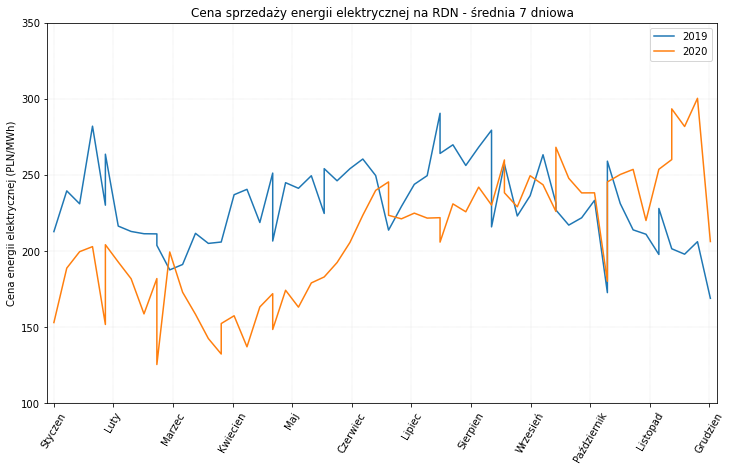

In [75]:
fig, ax = plt.subplots(figsize=(12,7))
plt.title('Cena sprzedaży energii elektrycznej na RDN - średnia 7 dniowa')
plt.plot(df2019_weekly['week'], df2019_weekly['fixing I course (PLN/MWh)'], label = "2019")
plt.plot(df2020_weekly['week'], df2020_weekly['fixing I course (PLN/MWh)'], label = "2020")
plt.grid(color='gray', linestyle=':', linewidth=0.35, alpha=0.6, axis='both')



x = np.arange(1, 52, 4.63)
labels = ['Styczen', 'Luty', 'Marzec', 'Kwiecien', 'Maj', 'Czerwiec', 'Lipiec', 'Sierpien', 'Wrzesień', 
          'Październik', 'Listopad', 'Grudzien']

plt.xticks(x, labels, rotation=60)

plt.ylabel("Cena energii elektrycznej (PLN/MWh)")
plt.margins(0.01)
plt.legend()
plt.yticks(np.arange(100, 400, 50))


plt.show()


In [76]:
df

,date,fixing I course (PLN/MWh),month,month_name,hour,week,date_normalize,day_of_week,day_of_month,md,season,pl_weekday,pl_month_name,pl_season_name,quarter
0,2019-01-02 01:00:00,40.00,1.0,January,1.0,1.0,2019-01-02,2.0,2.0,01-02,Winter,Środa,Styczeń,Zima,1
1,2019-01-02 02:00:00,31.00,1.0,January,2.0,1.0,2019-01-02,2.0,2.0,01-02,Winter,Środa,Styczeń,Zima,1
2,2019-01-02 03:00:00,31.00,1.0,January,3.0,1.0,2019-01-02,2.0,2.0,01-02,Winter,Środa,Styczeń,Zima,1
3,2019-01-02 04:00:00,31.00,1.0,January,4.0,1.0,2019-01-02,2.0,2.0,01-02,Winter,Środa,Styczeń,Zima,1
4,2019-01-02 05:00:00,31.00,1.0,January,5.0,1.0,2019-01-02,2.0,2.0,01-02,Winter,Środa,Styczeń,Zima,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17418,2020-12-26 19:00:00,198.81,12.0,December,19.0,52.0,2020-12-26,5.0,26.0,12-26,Winter,Sobota,Grudzień,Zima,4
17419,2020-12-26 20:00:00,195.00,12.0,December,20.0,52.0,2020-12-26,5.0,26.0,12-26,Winter,Sobota,Grudzień,Zima,4
17420,2020-12-26 21:00:00,186.03,12.0,December,21.0,52.0,2020-12-26,5.0,26.0,12-26,Winter,Sobota,Grudzień,Zima,4
17421,2020-12-26 22:00:00,174.75,12.0,December,22.0,52.0,2020-12-26,5.0,26.0,12-26,Winter,Sobota,Grudzień,Zima,4


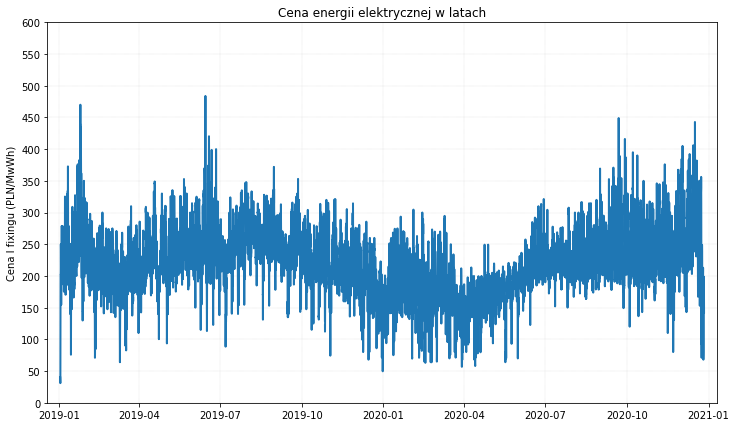

In [77]:
fig = plt.subplots(figsize=(12,7))

plt.plot(df['date'], df['fixing I course (PLN/MWh)'], label = 'line 1',
        linewidth=2.0)

# plt.fill_between(df2019_daily['date_normalize'], df2019_daily['fixing I course (PLN/MWh)'], alpha=0.2)
plt.title('Cena energii elektrycznej w latach',fontsize=12)
my_xticks = np.array(df['date_normalize'])
# frequency = 30
# plt.xticks(my_xticks[::frequency], my_xticks[::frequency], rotation=60)
plt.ylabel("Cena I fixingu (PLN/MwWh)")
plt.margins(0.02)
plt.ylim(120,270, 30)
plt.yticks(np.arange(0, 650, 50))

plt.grid(color='gray', linestyle=':', linewidth=0.35, alpha=0.6, axis='both')
#plt.grid()



plt.show()

In [78]:
new_df = df_fx_hourly[0:20]
new_df['fixing I course (PLN/MWh)'][0] = 167.4
new_df['fixing I course (PLN/MWh)'][1] = 171.1
new_df['fixing I course (PLN/MWh)'][2] = 171.5
new_df['fixing I course (PLN/MWh)'][3] = 168.9
new_df['fixing I course (PLN/MWh)'][4] = 160.6
new_df['fixing I course (PLN/MWh)'][5] = 162.5
new_df['fixing I course (PLN/MWh)'][6] = 167.9
new_df['fixing I course (PLN/MWh)'][7] = 164
new_df['fixing I course (PLN/MWh)'][8] = 174.9
new_df['fixing I course (PLN/MWh)'][9] = 186.2
new_df['fixing I course (PLN/MWh)'][10] = 208.8
new_df['fixing I course (PLN/MWh)'][11] = 205.5
new_df['fixing I course (PLN/MWh)'][12] = 241.8
new_df['fixing I course (PLN/MWh)'][13] = 247.2
new_df['fixing I course (PLN/MWh)'][14] = 252.6
new_df['fixing I course (PLN/MWh)'][15] = 241.4
new_df['fixing I course (PLN/MWh)'][16] = 250.9
new_df['fixing I course (PLN/MWh)'][17] = 245.4
new_df['fixing I course (PLN/MWh)'][18] = 258
new_df['fixing I course (PLN/MWh)'][19] = 256.2

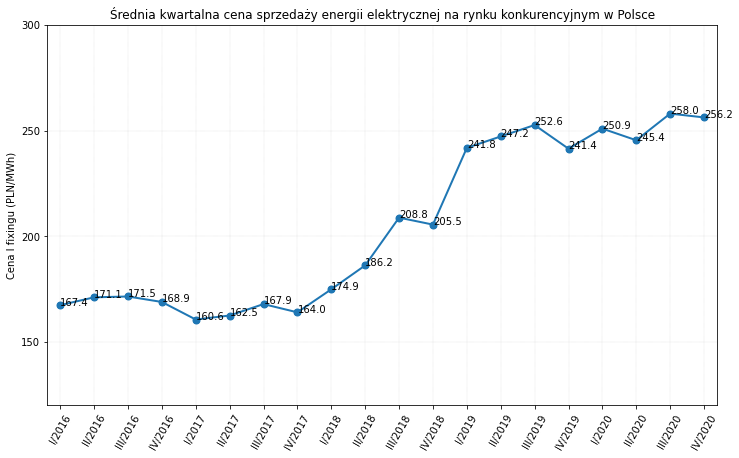

In [79]:
fig, ax = plt.subplots(figsize=(12,7))

plt.plot(new_df['h-m'], new_df['fixing I course (PLN/MWh)'], linewidth=2.0, marker='.', ms=14)

plt.title('Średnia kwartalna cena sprzedaży energii elektrycznej na rynku konkurencyjnym w Polsce')
# my_xticks = np.array(new_df['h-m'])
# frequency = 2
# plt.xticks(my_xticks[::frequency], my_xticks[::frequency], rotation=0)
plt.ylabel("Cena I fixingu (PLN/MWh)")
plt.margins(0.02)
plt.ylim(120,270, 30)
plt.yticks(np.arange(150, 350, 50))
x=["I/2016","II/2016","III/2016", "IV/2016", "I/2017", "II/2017", "III/2017", "IV/2017", "I/2018", "II/2018", "III/2018", "IV/2018", 
  "I/2019","II/2019","III/2019", "IV/2019", "I/2020","II/2020","III/2020", "IV/2020"]
plt.grid(color='gray', linestyle=':', linewidth=0.35, alpha=0.6, axis='both')

ax.scatter(new_df['h-m'], new_df['fixing I course (PLN/MWh)'])

for i, txt in enumerate(new_df['fixing I course (PLN/MWh)']):
    ax.annotate(txt, (new_df['h-m'][i], new_df['fixing I course (PLN/MWh)'][i]))
#plt.xticks(x, rotation=60)
ax.set_xticks(new_df['h-m'])
        # Set the tick labels
ax.set_xticklabels(x, rotation = 60)
#plt.grid()

plt.show()


In [80]:
df2019_daily = df2019.groupby(['date_normalize', 'pl_month_name']).agg({'fixing I course (PLN/MWh)':np.mean}).reset_index() 
df2019_daily['day_of_year'] = pd.to_datetime(df2019_daily['date_normalize']).dt.dayofyear

df2020_daily = df2020.groupby(['date_normalize', 'pl_month_name']).agg({'fixing I course (PLN/MWh)':np.mean}).reset_index() 
df2020_daily['day_of_year'] = pd.to_datetime(df2020_daily['date_normalize']).dt.dayofyear

In [81]:
index_ = [pd.to_datetime(date, format='%Y-%m-%d').date() 
        for date in pd.date_range('2004-03-01', '2012-12-01', freq="M")]

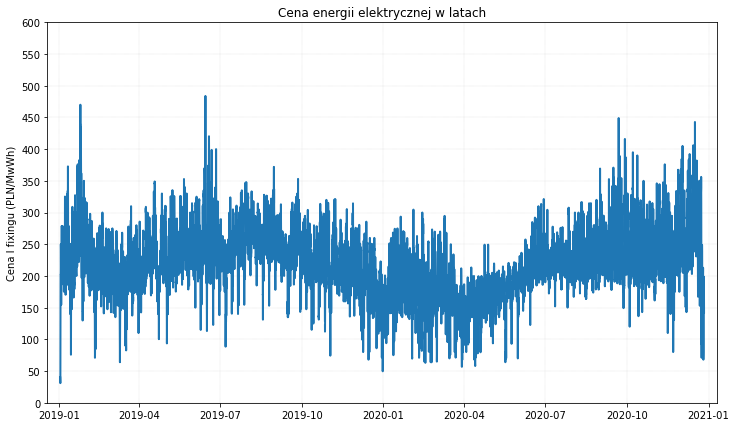

In [82]:
fig = plt.subplots(figsize=(12,7))

plt.plot(df['date'], df['fixing I course (PLN/MWh)'], label = 'line 1',
        linewidth=2.0)

# plt.fill_between(df2019_daily['date_normalize'], df2019_daily['fixing I course (PLN/MWh)'], alpha=0.2)
plt.title('Cena energii elektrycznej w latach',fontsize=12)
my_xticks = np.array(df['date_normalize'])
# frequency = 30
# plt.xticks(my_xticks[::frequency], my_xticks[::frequency], rotation=60)
plt.ylabel("Cena I fixingu (PLN/MwWh)")
plt.margins(0.02)
plt.ylim(120,270, 30)
plt.yticks(np.arange(0, 650, 50))

plt.grid(color='gray', linestyle=':', linewidth=0.35, alpha=0.6, axis='both')
#plt.grid()



plt.show()

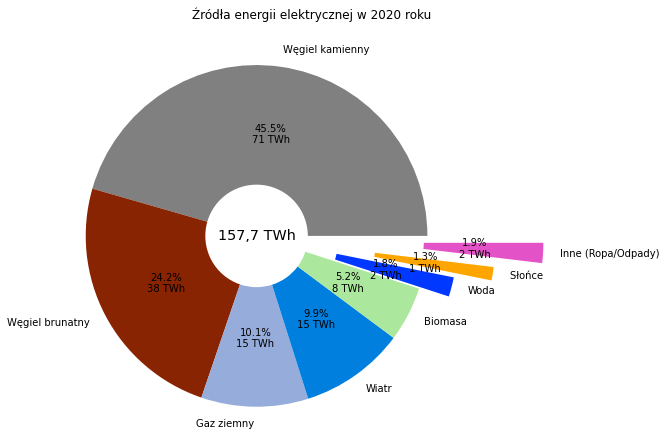

In [83]:
cars = ['Węgiel kamienny', 'Węgiel brunatny', 'Gaz ziemny', 
        'Wiatr', 'Biomasa', 'Woda', 'Słońce ', 'Inne (Ropa/Odpady)']
  
data = [72, 38.3, 16, 15.7, 8.2, 2.9, 2, 3]

explode = (0.00, 0.00, 0.00, 0.00, 0.0, 0.18, 0.40, 0.68)
  
# Creating color parameters
colors = ( 'gray', '#892402', '#96acdb',
          '#007fdf', "#abe89d", "#0038ff", 'orange', "#e352c7")
  
    
    
# Wedge properties
wp = { 'linewidth' : 1, 'edgecolor' : "black" }
  
# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n{:.0f} TWh".format(pct, absolute)
  
# Creating plot
fig, ax = plt.subplots(figsize =(10, 7))
wedges, texts, autotexts = ax.pie(data, 
                                  autopct = lambda pct: func(pct, data),
                                  explode = explode, 
                                  labels = cars,
                                  shadow = False,
                                  colors = colors,
                                  startangle = 360,
                                  wedgeprops=dict(width=0.7),
                                #  wedgeprops = wp,
                                  textprops = dict(color ="black"))
  

sumstr = '157,7 TWh'  
plt.setp(autotexts, size = 10)
# String on the donut center
ax.text(0., 0., sumstr, horizontalalignment='center', verticalalignment='center', size = 'x-large')

ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.set_title("Źródła energii elektrycznej w 2020 roku")
ttl = ax.title
ttl.set_position([.5, 1.05])
# show plot
plt.show()

In [84]:
filepath = 'AMZN_2006-01-01_to_2018-01-01.csv'
data = pd.read_csv(filepath)
data = data.sort_values('Date')
data.head()


,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN
1,2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN
2,2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN
3,2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN
4,2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN


In [85]:
data['Date'].loc[::500]

0       2006-01-03
500     2007-12-28
1000    2009-12-22
1500    2011-12-16
2000    2013-12-13
2500    2015-12-09
3000    2017-12-04
Name: Date, dtype: object

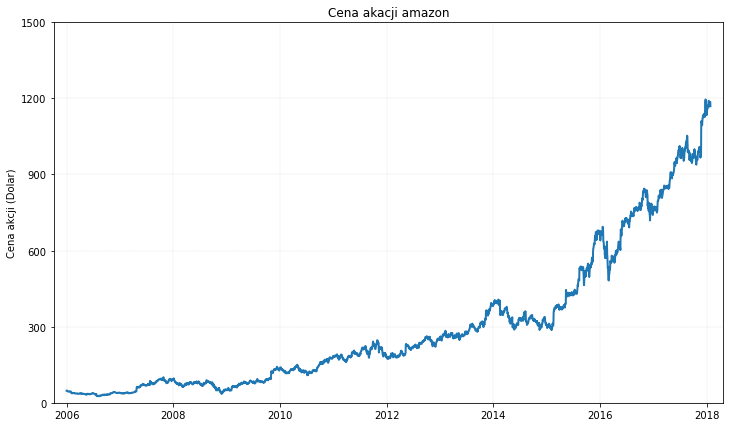

In [86]:
fig, ax = plt.subplots(figsize=(12,7))

plt.plot(data['Date'], data['Close'], label = 'line 1', linewidth=2.0)

# plt.fill_between(df2019_daily['date_normalize'], df2019_daily['fixing I course (PLN/MWh)'], alpha=0.2)
plt.title('Cena akacji amazon')
plt.ylabel("Cena akcji (Dolar)")
plt.margins(0.02)

plt.yticks(np.arange(0, 1700, 300))
plt.xticks(range(0,data.shape[0],500),data['Date'].loc[::500])


x=["2006","2008","2010", "2012", "2014", "2016", "2018"]
plt.grid(color='gray', linestyle=':', linewidth=0.35, alpha=0.6, axis='both')

ax.set_xticks(data['Date'].loc[::500])
ax.set_xticklabels(x, rotation = 0)
plt.show()

In [87]:
popyt = pd.DataFrame({"x":[1, 2, 3, 4, 5, 6,7,8,9,10,11,12,13,14,15,16,17,18,19, 20,21,22,23,24,25,26,27,28,29],
                         "y":[1, 1, 1, 1, 3, 3, 3, 3, 5, 5, 5.4, 5.4, 5.4, 5.4, 5.4, 5.4,  6.3,
                              6.3,  6.3, 6.8, 7.5, 7.5, 7.5, 7.5, 8.6, 8.6, 9.5, 11.5, 11.5]})

In [88]:
podaz = pd.DataFrame({"x":[1, 2, 3, 4, 5, 6,7,8,9,10,11,12,13,14,15,16,17,18,19, 20,21,22,23,24,25,26,27,28,29],
                         "y":[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 10, 10, 10,  9,
                              9,  8.5, 8.5, 8.5, 8.5, 6, 6, 6, 5,5, 4, 4]})

In [89]:
punkt_przeciecia = pd.DataFrame({"x":[1, 22, 22],
                         "y":[7.5, 7.5, 0]})

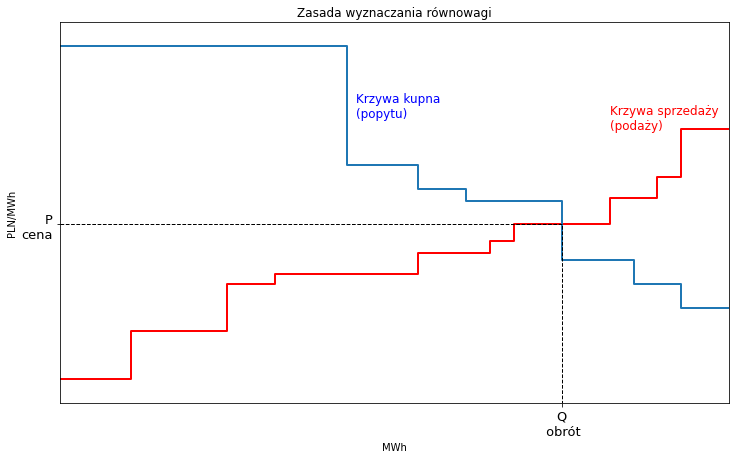

In [90]:
fig, ax= plt.subplots(figsize=(12,7))

plt.plot(popyt['x'], popyt['y'], ls='steps',
        linewidth=2.0, color = 'red')
plt.plot(podaz['x'], podaz['y'], ls='steps',
        linewidth=2.0)
plt.plot(punkt_przeciecia['x'], punkt_przeciecia['y'],
        linewidth=1.0, ls='steps', color='black', linestyle='--')
plt.title('Zasada wyznaczania równowagi')
my_xticks = np.array(popyt['x'])

plt.xticks( rotation=0)
plt.ylabel("Cena I fixingu (PLN)")
plt.margins(0.)
#plt.ylim(120,270, 30)
plt.yticks(np.arange(0, 17, 1))
plt.xlabel("MWh")
plt.ylabel("PLN/MWh")
#plt.grid()
plt.annotate('Krzywa sprzedaży\n(podaży)', xy=(11, 10), xytext=(24, 11.5), fontsize=12, color='red')
plt.annotate('Krzywa kupna\n(popytu)', xy=(11, 10), xytext=(13.4, 12), fontsize=12, color = 'blue')
x=["Q\n obrót"]
ax.set_xticklabels(x, rotation = 0,fontsize=13)
x=["P\ncena"]
ax.set_yticklabels(x, rotation = 0,fontsize=13)

plt.xticks([22])
plt.yticks([7.5])
plt.show()

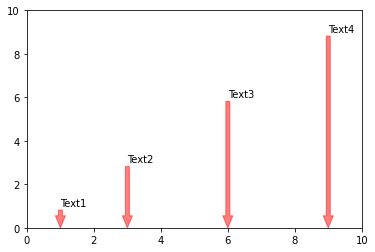

In [91]:
from matplotlib import pyplot as plt
plt.figure()
plt.annotate('Text1', xy=(1, 0), xytext=(1, 1), 
        arrowprops=dict(alpha=0.5, fc='r', ec='r', headwidth=10, frac=0.5/1))
plt.annotate('Text2', xy=(3, 0), xytext=(3, 3), 
        arrowprops=dict(alpha=0.5, fc='r', ec='r', headwidth=10, frac=0.5/3))
plt.annotate('Text3', xy=(6, 0), xytext=(6, 6), 
        arrowprops=dict(alpha=0.5, fc='r', ec='r', headwidth=10, frac=0.5/6))
plt.annotate('Text4', xy=(9, 0), xytext=(9, 9), 
        arrowprops=dict(alpha=0.5, fc='r', ec='r', headwidth=10, frac=0.5/9))
plt.xlim((0, 10))
plt.ylim(0, 10)
plt.show()

In [92]:
df

,date,fixing I course (PLN/MWh),month,month_name,hour,week,date_normalize,day_of_week,day_of_month,md,season,pl_weekday,pl_month_name,pl_season_name,quarter
0,2019-01-02 01:00:00,40.00,1.0,January,1.0,1.0,2019-01-02,2.0,2.0,01-02,Winter,Środa,Styczeń,Zima,1
1,2019-01-02 02:00:00,31.00,1.0,January,2.0,1.0,2019-01-02,2.0,2.0,01-02,Winter,Środa,Styczeń,Zima,1
2,2019-01-02 03:00:00,31.00,1.0,January,3.0,1.0,2019-01-02,2.0,2.0,01-02,Winter,Środa,Styczeń,Zima,1
3,2019-01-02 04:00:00,31.00,1.0,January,4.0,1.0,2019-01-02,2.0,2.0,01-02,Winter,Środa,Styczeń,Zima,1
4,2019-01-02 05:00:00,31.00,1.0,January,5.0,1.0,2019-01-02,2.0,2.0,01-02,Winter,Środa,Styczeń,Zima,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17418,2020-12-26 19:00:00,198.81,12.0,December,19.0,52.0,2020-12-26,5.0,26.0,12-26,Winter,Sobota,Grudzień,Zima,4
17419,2020-12-26 20:00:00,195.00,12.0,December,20.0,52.0,2020-12-26,5.0,26.0,12-26,Winter,Sobota,Grudzień,Zima,4
17420,2020-12-26 21:00:00,186.03,12.0,December,21.0,52.0,2020-12-26,5.0,26.0,12-26,Winter,Sobota,Grudzień,Zima,4
17421,2020-12-26 22:00:00,174.75,12.0,December,22.0,52.0,2020-12-26,5.0,26.0,12-26,Winter,Sobota,Grudzień,Zima,4


In [93]:
df_fx_hourly = df.groupby(['hour']).agg({'fixing I course (PLN/MWh)':np.mean})
df_fx_hourly = df_fx_hourly.reset_index() 

In [106]:
new_df = df_fx_hourly[0:20]
new_df['fixing I course (PLN/MWh)'][0] = 5.4
new_df['fixing I course (PLN/MWh)'][1] = 5.7
new_df['fixing I course (PLN/MWh)'][2] = 4.5
new_df['fixing I course (PLN/MWh)'][3] = 5.4
new_df['fixing I course (PLN/MWh)'][4] = 5.1
new_df['fixing I course (PLN/MWh)'][5] = 4.8
new_df['fixing I course (PLN/MWh)'][6] = 5.9
new_df['fixing I course (PLN/MWh)'][7] = 7.4
new_df['fixing I course (PLN/MWh)'][8] = 9.7
new_df['fixing I course (PLN/MWh)'][9] = 14.3
new_df['fixing I course (PLN/MWh)'][10] = 18.6
new_df['fixing I course (PLN/MWh)'][11] = 19.4
new_df['fixing I course (PLN/MWh)'][12] = 21.8
new_df['fixing I course (PLN/MWh)'][13] = 21.8
new_df['fixing I course (PLN/MWh)'][14] = 27.0
new_df['fixing I course (PLN/MWh)'][15] = 24.6
new_df['fixing I course (PLN/MWh)'][16] = 22.5
new_df['fixing I course (PLN/MWh)'][17] = 21.2
new_df['fixing I course (PLN/MWh)'][18] = 27.2
new_df['fixing I course (PLN/MWh)'][19] = 26.5


In [107]:
new_df

,hour,fixing I course (PLN/MWh)
0,0.0,5.4
1,1.0,5.7
2,2.0,4.5
3,3.0,5.4
4,4.0,5.1
5,5.0,4.8
6,6.0,5.9
7,7.0,7.4
8,8.0,9.7
9,9.0,14.3


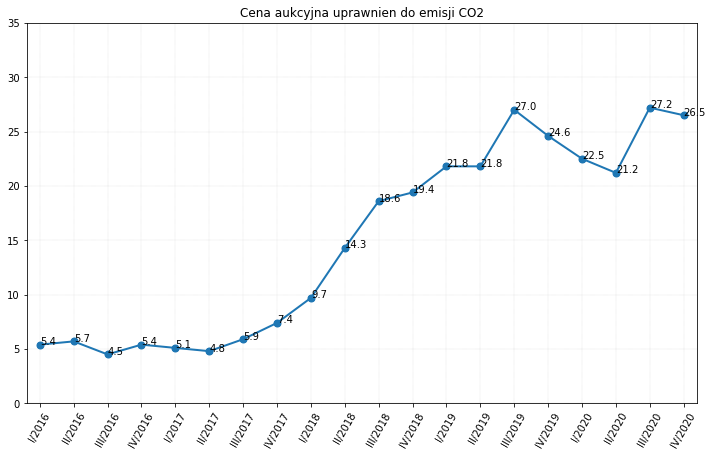

In [109]:
fig, ax = plt.subplots(figsize=(12,7))

plt.plot(new_df['hour'], new_df['fixing I course (PLN/MWh)'], linewidth=2.0, marker='.', ms=14)

plt.title('Cena aukcyjna uprawnien do emisji CO2')
# my_xticks = np.array(new_df['h-m'])
# frequency = 2
# plt.xticks(my_xticks[::frequency], my_xticks[::frequency], rotation=0)
#plt.ylabel("Cena I fixingu (PLN/MWh)")
plt.margins(0.02)

plt.ylim(0,35, 5)
plt.yticks(np.arange(0, 40, 5))
x=["I/2016","II/2016","III/2016", "IV/2016", "I/2017", "II/2017", "III/2017", "IV/2017", "I/2018", "II/2018", "III/2018", "IV/2018", 
  "I/2019","II/2019","III/2019", "IV/2019", "I/2020","II/2020","III/2020", "IV/2020"]
plt.grid(color='gray', linestyle=':', linewidth=0.35, alpha=0.6, axis='both')

ax.scatter(new_df['hour'], new_df['fixing I course (PLN/MWh)'])

for i, txt in enumerate(new_df['fixing I course (PLN/MWh)']):
    ax.annotate(txt, (new_df['hour'][i], new_df['fixing I course (PLN/MWh)'][i]))
#plt.xticks(x, rotation=60)
ax.set_xticks(new_df['hour'])
        # Set the tick labels
ax.set_xticklabels(x, rotation = 60)
#plt.grid()

plt.show()
